
Logistic Regression — Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       194
           1       0.68      0.56      0.61        68

    accuracy                           0.82       262
   macro avg       0.77      0.73      0.75       262
weighted avg       0.81      0.82      0.81       262



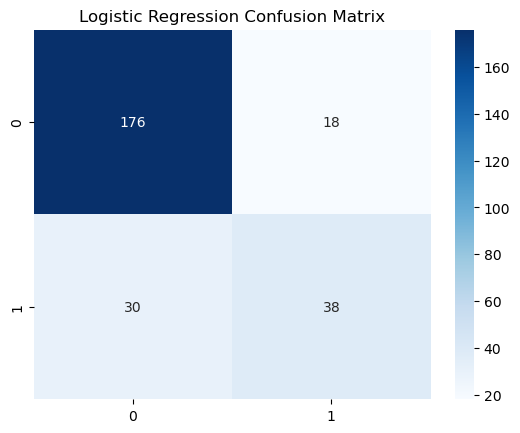


Decision Tree — Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       194
           1       0.64      0.66      0.65        68

    accuracy                           0.82       262
   macro avg       0.76      0.77      0.76       262
weighted avg       0.82      0.82      0.82       262



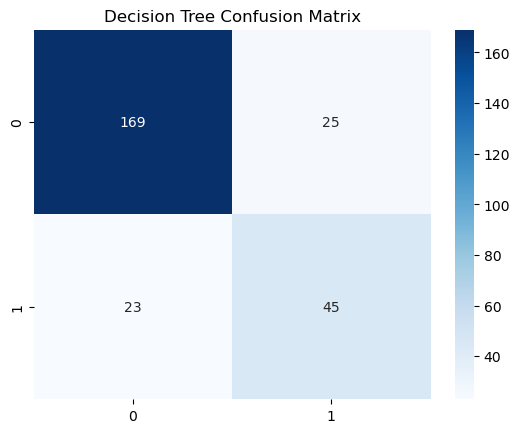


Random Forest — Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       194
           1       0.86      0.63      0.73        68

    accuracy                           0.88       262
   macro avg       0.87      0.80      0.82       262
weighted avg       0.88      0.88      0.87       262



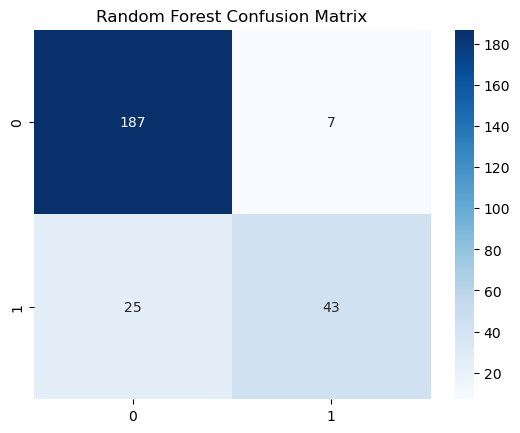

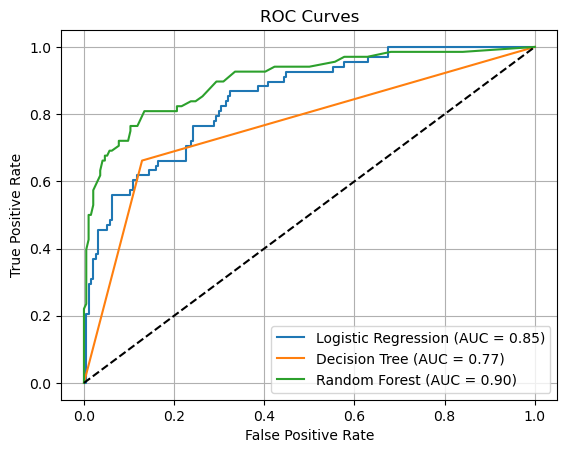

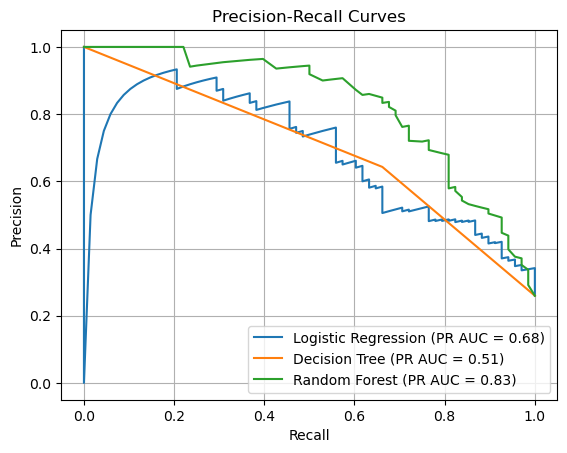


Метрики класифікації для моделей:

                     Accuracy  Precision (macro)  Recall (macro)  F1 (macro)  \
Logistic Regression  0.816794           0.766470        0.733020    0.746452   
Decision Tree        0.816794           0.761533        0.766449    0.763911   
Random Forest        0.877863           0.871038        0.798135    0.824998   

                     F1 (beta=0.5)  F1 (beta=2)   ROC AUC    PR AUC  
Logistic Regression       0.650685     0.579268  0.848241  0.683972  
Decision Tree             0.646552     0.657895  0.766449  0.513206  
Random Forest             0.802239     0.667702  0.902896  0.825202  

Вплив дисбалансу класів на метрики:

       Accuracy  Precision    Recall        F1   ROC AUC
50-50  0.961240   0.932039  0.994819  0.962406  0.992081
30-70  0.938628   0.902439  0.891566  0.896970  0.965719
10-90  0.939535   0.785714  0.523810  0.628571  0.849043
1-99   0.989796   0.000000  0.000000  0.000000  0.927835


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, fbeta_score)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Завантаження даних ---
data = pd.read_csv("train_and_test2.csv")
data.dropna(inplace=True)

# --- Підготовка ---
X = data.drop(columns=["2urvived"])
y = data["2urvived"].astype(int)

# Кодування категоріальних
X = pd.get_dummies(X, drop_first=True)

# Стандартизація
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# --- Моделі ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average="macro"),
        "Recall (macro)": recall_score(y_test, y_pred, average="macro"),
        "F1 (macro)": f1_score(y_test, y_pred, average="macro"),
        "F1 (beta=0.5)": fbeta_score(y_test, y_pred, beta=0.5),
        "F1 (beta=2)": fbeta_score(y_test, y_pred, beta=2),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "PR AUC": average_precision_score(y_test, y_proba)
    }
    
    print(f"\n{name} — Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
# --- ROC curves ---
plt.figure()
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# --- Precision-Recall curves ---
plt.figure()
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {average_precision_score(y_test, y_proba):.2f})")

plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# --- Таблиця з метриками ---
df_metrics = pd.DataFrame(metrics).T
print("\nМетрики класифікації для моделей:\n")
print(df_metrics)

# --- Експеримент з дисбалансом ---
from sklearn.utils import resample

def imbalance_test(ratio):
    df_bal = pd.concat([X, y], axis=1)
    class_0 = df_bal[df_bal["2urvived"] == 0]
    class_1 = df_bal[df_bal["2urvived"] == 1]
    
    size_1 = int(len(class_0) * ratio / (1 - ratio))
    class_1_down = resample(class_1, replace=True, n_samples=size_1, random_state=42)
    
    df_new = pd.concat([class_0, class_1_down])
    X_new = df_new.drop(columns=["2urvived"])
    y_new = df_new["2urvived"]
    
    Xn_scaled = scaler.fit_transform(pd.get_dummies(X_new, drop_first=True))
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(Xn_scaled, y_new, test_size=0.2, stratify=y_new, random_state=42)
    
    model = RandomForestClassifier().fit(X_train_n, y_train_n)
    y_pred_n = model.predict(X_test_n)
    y_proba_n = model.predict_proba(X_test_n)[:, 1]
    
    return {
        "Accuracy": accuracy_score(y_test_n, y_pred_n),
        "Precision": precision_score(y_test_n, y_pred_n),
        "Recall": recall_score(y_test_n, y_pred_n),
        "F1": f1_score(y_test_n, y_pred_n),
        "ROC AUC": roc_auc_score(y_test_n, y_proba_n)
    }

ratios = [0.5, 0.3, 0.1, 0.01]
imbalance_results = pd.DataFrame({f"{int(r*100)}-{int((1-r)*100)}": imbalance_test(r) for r in ratios}).T
print("\nВплив дисбалансу класів на метрики:\n")
print(imbalance_results)
